# Jollyes Data Science Task

This notebook is a solution to a task set for the Jollyes Data Scientist position through the following steps:

- Data import, preparation and analysis
- Modelling a collaborative filtering approach for higher volume SKUs
- Modelling a simple tf-idf similarity approach for low-volume SKUs
- Combining models into a hybrid output

### Imports and setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [2]:
# Import data
skus = pd.read_csv('resources/skus.csv')
transactions = pd.read_csv('resources/transactions.csv')

### General Data Prep and Analysis

In [3]:
# Remove discount vouchers and delivery (not purchasable) and negative quantity transactions
skus_clean = skus.loc[~skus['SKU'].isin([65596, 65597, 65598, 30365])].reset_index(drop=True)
transactions_clean = transactions.loc[~transactions['SKU'].isin([65596, 65597, 65598, 30365])]
transactions_clean = transactions_clean.loc[transactions['QTY']>=0].reset_index(drop=True)

### Collaborative Filtering Approach
Use past mutli-item transactions to work out which items are likely to be purchased together. This approach is only suitable when we have multiple examples of cases where a SKU has been purchased with other items, so has limited value with this small set of transactions. 

In [4]:
# Create a matrix of transaction ID to SKUs purchased
transactions_all_sku = skus_clean[['SKU']].merge(transactions_clean, on='SKU', how='left').fillna(0)
transaction_sku_qty_df = transactions_all_sku.pivot_table(index='TRANSACTION_ID', columns='SKU', values='QTY', aggfunc='sum')
transaction_sku_qty = np.array(transaction_sku_qty_df)

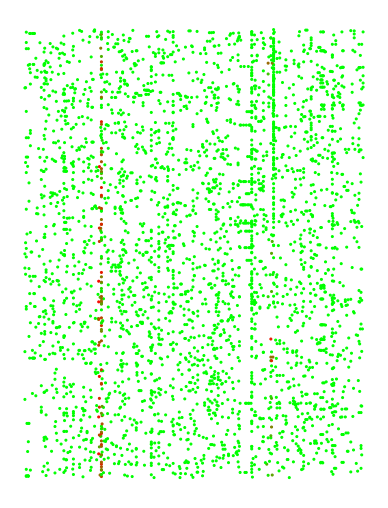

In [5]:
# Plot which transactions contains which SKUs (color coded by QTY) 
x,y = transaction_sku_qty.nonzero()
plt.figure(figsize=(6, 8), dpi=80)
plt.scatter(y,x,s=3,vmin=-1., vmax=1.,c=transaction_sku_qty[x,y], cmap='brg')
plt.axis('off')
plt.show()

In [6]:
# Modify data to use a flag of SKU included rather than quantity
# QTY does not appear to be a good indicator of preference as some products are commonly bought in bulk or non-integer QTY (see above)
transaction_sku = np.where(transaction_sku_qty>0, 1, 0)

# Filter to multi-SKU transactions for the collaborative filtering algorithm
transaction_sku_multi = transaction_sku[transaction_sku.sum(axis=1)>1]

# Normalize the matrix to avoid large transactions skewing results 
mean_transaction_size = np.mean(transaction_sku_multi, axis=1).reshape(-1, 1)
normalized_transaction_sku = transaction_sku_multi - mean_transaction_size

# Fit a kNN model based on transaction vector similarity
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(normalized_transaction_sku)

NearestNeighbors(algorithm='brute', metric='cosine')

In [7]:
# Generate SKUs to be scored as 'transactions' containing each single SKU
scored_transactions = np.identity(skus_clean.shape[0])
# Normalise to match training set
mean_transaction_size = np.mean(scored_transactions, axis=1).reshape(-1, 1)
scored_transactions_norm = scored_transactions - mean_transaction_size

# Get the 10 closest distances to each SKU
distances, indices = knn.kneighbors(scored_transactions_norm, n_neighbors=5)

# Aggregate ratings from the nearest neighbors 
neighbors_ratings = transaction_sku[indices]
predicted_ratings = neighbors_ratings.mean(axis=1)

In [8]:
# Ignore recommendations for the same SKU
predicted_ratings_adj = np.where(scored_transactions==1, 0, predicted_ratings)

### Review results of Collaborative Filtering approach

In [9]:
# Function to convert the indexes of the top rated SKUs into a readable DF
def create_rec_df(best_sku):
    df = pd.DataFrame(best_sku)
    df['SKU_ORIGINAL'] = skus_clean.SKU
    df['SKU_1'] = skus_clean.SKU.iloc[df[2]].reset_index(drop=True)
    df['SKU_2'] = skus_clean.SKU.iloc[df[1]].reset_index(drop=True)
    df['SKU_3'] = skus_clean.SKU.iloc[df[0]].reset_index(drop=True)

    df = df.merge(skus[['SKU', 'ITEM_DESCRIPTION', 'DEPARTMENT', 'CATEGORY']], left_on='SKU_ORIGINAL', right_on='SKU', how='left').drop(columns='SKU')
    df = df.merge(skus[['SKU', 'ITEM_DESCRIPTION', 'DEPARTMENT', 'CATEGORY']], left_on='SKU_1', right_on='SKU', how='left', suffixes=('','_1')).drop(columns='SKU')
    df = df.merge(skus[['SKU', 'ITEM_DESCRIPTION', 'DEPARTMENT', 'CATEGORY']], left_on='SKU_2', right_on='SKU', how='left', suffixes=('','_2')).drop(columns='SKU')
    df = df.merge(skus[['SKU', 'ITEM_DESCRIPTION', 'DEPARTMENT', 'CATEGORY']], left_on='SKU_3', right_on='SKU', how='left', suffixes=('','_3')).drop(columns='SKU')

    return df


In [10]:
# Convert scores to top 3 SKUs in readable format
best_sku_collab = np.argsort(predicted_ratings_adj, axis=1)[:,-3::]
out_df_collab = create_rec_df(best_sku_collab)

In [11]:
out_df_collab[[
    'SKU_ORIGINAL',
    'ITEM_DESCRIPTION',
    'DEPARTMENT',
    'CATEGORY',
    'SKU_1',
    'ITEM_DESCRIPTION_1',
    'DEPARTMENT_1',
    'CATEGORY_1',
    'SKU_2',
    'ITEM_DESCRIPTION_2',
    'DEPARTMENT_2',
    'CATEGORY_2',
    'SKU_3',
    'ITEM_DESCRIPTION_3',
    'DEPARTMENT_3',
    'CATEGORY_3',
]]

,SKU_ORIGINAL,ITEM_DESCRIPTION,DEPARTMENT,CATEGORY,SKU_1,ITEM_DESCRIPTION_1,DEPARTMENT_1,CATEGORY_1,SKU_2,ITEM_DESCRIPTION_2,DEPARTMENT_2,CATEGORY_2,SKU_3,ITEM_DESCRIPTION_3,DEPARTMENT_3,CATEGORY_3
0,65142,Paddock Farm Chicken Feet,Dog,Treat,52265,Adult Dog Gf Chicken,Dog,Food,51074,Boxby Lamb Trainers,Dog,Treat,62384,Chicken And Cheese,Dog,Treat
1,65145,Paddock Farm Duck Feet,Dog,Treat,54660,Lamb Dinner,Dog,Food,11916,Pb Meaty Ham Bone,Dog,Treat,20641,Bakers Dental Delicious Chickn,Dog,Treat
2,65147,P Farm Puffed Chicken Feet,Dog,Treat,52711,Puppy Turkey And Potato,Dog,Food,52775,Prime Chicken Fillets,Dog,Treat,66971,Turkey Goose N Cranberry,Dog,Food
3,66515,Smiley Face Doggy Play Balls,Dog,Toys,20603,Back2nature Sa Bedding+Litter,Sm.Animal,Accessory,65410,Yakers Chew Cranberry Medium,Dog,Treat,54665,Scottish Salmon Dinner,Dog,Food
4,66502,Dog Primary 1st Vac Vanguard,Services,Vet,63238,Timothy Rich Hay With Carrot,Sm.Animal,Food,56331,Vanilla Woofin Cake,Dog,Treat,54716,Peanut Kernels,Wildbird,Food
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,66607,Xl Cow Ears With Hair,Dog,Treat,51337,Variety Pack Cans,Dog,Food,62384,Chicken And Cheese,Dog,Treat,54658,Game And Tripe Dinner,Dog,Food
492,66609,Lamb Ears With Hair,Dog,Treat,20603,Back2nature Sa Bedding+Litter,Sm.Animal,Accessory,54657,Duck Dinner,Dog,Food,50353,Chewy Stick W Duck,Dog,Treat
493,22047,Jollyes Clear Small Bags,Misc.,Other,65810,Ls Cow Ears 10 Pack,Dog,Treat,54659,Lamb N Chicken Dinner With Veg,Dog,Food,53409,Empty Dried Hooves,Dog,Treat
494,65495,Chicken Mince,Dog,Food,51306,Nvd Fd Bites Lamb,Dog,Treat,62384,Chicken And Cheese,Dog,Treat,27018,Lick E Lix Chicken,Cat,Treat


### Content-Based Approach

In [12]:
content_df = skus_clean[[
    # Features for product similarity
    'ITEM_DESCRIPTION',
    'DEPARTMENT',
    'CATEGORY',
    'SUBCATEGORY1',
    'BRAND',
    # 'ITEM_WEIGHT'
]]
# Create single string with all content included
content_df['Content'] = content_df.apply(lambda row: ' '.join(row.dropna().astype(str)), axis=1)

# Convert text data to tf-idf vectors and calculate similarity
tfidf_vectorizer = TfidfVectorizer()
content_matrix = tfidf_vectorizer.fit_transform(content_df['Content'])
content_similarity = linear_kernel(content_matrix, content_matrix)

/var/folders/gs/zrjdwm714r1fpj6csntklm3m0000gn/T/ipykernel_31118/3355458671.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content_df['Content'] = content_df.apply(lambda row: ' '.join(row.dropna().astype(str)), axis=1)


In [13]:
# Ignore recommendations for the same SKU
content_similarity_adj = content_similarity.copy()
content_similarity_adj[content_similarity_adj.round(3)==1] = 0

### Review results of Content-Based approach

In [14]:
# Select the highest scoring 3 SKUs
best_sku_content = np.argsort(content_similarity_adj, axis=1)[:,-3::]
out_df_content = create_rec_df(best_sku_content)

In [15]:
out_df_content[[
    'SKU_ORIGINAL',
    'ITEM_DESCRIPTION',
    'DEPARTMENT',
    'CATEGORY',
    'SKU_1',
    'ITEM_DESCRIPTION_1',
    'DEPARTMENT_1',
    'CATEGORY_1',
    'SKU_2',
    'ITEM_DESCRIPTION_2',
    'DEPARTMENT_2',
    'CATEGORY_2',
    'SKU_3',
    'ITEM_DESCRIPTION_3',
    'DEPARTMENT_3',
    'CATEGORY_3',
]]

,SKU_ORIGINAL,ITEM_DESCRIPTION,DEPARTMENT,CATEGORY,SKU_1,ITEM_DESCRIPTION_1,DEPARTMENT_1,CATEGORY_1,SKU_2,ITEM_DESCRIPTION_2,DEPARTMENT_2,CATEGORY_2,SKU_3,ITEM_DESCRIPTION_3,DEPARTMENT_3,CATEGORY_3
0,65142,Paddock Farm Chicken Feet,Dog,Treat,65145,Paddock Farm Duck Feet,Dog,Treat,65147,P Farm Puffed Chicken Feet,Dog,Treat,66599,Tripe Sticks,Dog,Treat
1,65145,Paddock Farm Duck Feet,Dog,Treat,65142,Paddock Farm Chicken Feet,Dog,Treat,65147,P Farm Puffed Chicken Feet,Dog,Treat,66599,Tripe Sticks,Dog,Treat
2,65147,P Farm Puffed Chicken Feet,Dog,Treat,65142,Paddock Farm Chicken Feet,Dog,Treat,65145,Paddock Farm Duck Feet,Dog,Treat,66599,Tripe Sticks,Dog,Treat
3,66515,Smiley Face Doggy Play Balls,Dog,Toys,65661,Tennis Balls,Dog,Toys,66304,Wind Up & Go Spider Cat Chase,Cat,Toys,62426,Cat Naturals Mini Catnip Balls,Cat,Toys
4,66502,Dog Primary 1st Vac Vanguard,Services,Vet,47535,Dog Primary 2nd Vac Van7 (Free,Services,Vet,62813,Nail Clip,Services,Grooming,62826,Full Haircut 12kg,Services,Grooming
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,66607,Xl Cow Ears With Hair,Dog,Treat,66609,Lamb Ears With Hair,Dog,Treat,66597,Rabbit Ears With Hair,Dog,Treat,52979,Buffalo Large Ears,Dog,Treat
492,66609,Lamb Ears With Hair,Dog,Treat,66607,Xl Cow Ears With Hair,Dog,Treat,66597,Rabbit Ears With Hair,Dog,Treat,52979,Buffalo Large Ears,Dog,Treat
493,22047,Jollyes Clear Small Bags,Misc.,Other,54690,Reusable Bag,Misc.,Other,63376,Treats For All Reusable Bag,Misc.,Other,63375,More Balls Please Reusable Bag,Misc.,Other
494,65495,Chicken Mince,Dog,Food,65786,Beef Mince,Dog,Food,63413,Beef Mince,Dog,Food,63416,Lamb Mince,Dog,Food


### Create a hybrid approach by combining the similarity scores from both approaches

In [16]:
# Normalise predictions from both methods for more intuitive combination
def normalise_row(a):
    row_max = a.max(axis=1)
    new_matrix = a / row_max[:, np.newaxis]
    return new_matrix

predicted_ratings_normalised = normalise_row(predicted_ratings_adj)
content_similarity_normalised = normalise_row(content_similarity_adj)

In [17]:
# Combine scores from each approach
combined_ratings = predicted_ratings_adj + content_similarity_adj

# Choose top 3 SKUs
best_sku = np.argsort(combined_ratings, axis=1)[:,-3::]
out_df = create_rec_df(best_sku)

In [18]:
out_df[[
    'SKU_ORIGINAL',
    'ITEM_DESCRIPTION',
    'DEPARTMENT',
    'CATEGORY',
    'SKU_1',
    'ITEM_DESCRIPTION_1',
    'DEPARTMENT_1',
    'CATEGORY_1',
    'SKU_2',
    'ITEM_DESCRIPTION_2',
    'DEPARTMENT_2',
    'CATEGORY_2',
    'SKU_3',
    'ITEM_DESCRIPTION_3',
    'DEPARTMENT_3',
    'CATEGORY_3',
]]

,SKU_ORIGINAL,ITEM_DESCRIPTION,DEPARTMENT,CATEGORY,SKU_1,ITEM_DESCRIPTION_1,DEPARTMENT_1,CATEGORY_1,SKU_2,ITEM_DESCRIPTION_2,DEPARTMENT_2,CATEGORY_2,SKU_3,ITEM_DESCRIPTION_3,DEPARTMENT_3,CATEGORY_3
0,65142,Paddock Farm Chicken Feet,Dog,Treat,65145,Paddock Farm Duck Feet,Dog,Treat,65147,P Farm Puffed Chicken Feet,Dog,Treat,66599,Tripe Sticks,Dog,Treat
1,65145,Paddock Farm Duck Feet,Dog,Treat,65142,Paddock Farm Chicken Feet,Dog,Treat,65147,P Farm Puffed Chicken Feet,Dog,Treat,66599,Tripe Sticks,Dog,Treat
2,65147,P Farm Puffed Chicken Feet,Dog,Treat,65142,Paddock Farm Chicken Feet,Dog,Treat,65145,Paddock Farm Duck Feet,Dog,Treat,66599,Tripe Sticks,Dog,Treat
3,66515,Smiley Face Doggy Play Balls,Dog,Toys,20603,Back2nature Sa Bedding+Litter,Sm.Animal,Accessory,54665,Scottish Salmon Dinner,Dog,Food,42046,Gb Chicken Twisters Value Pack,Dog,Treat
4,66502,Dog Primary 1st Vac Vanguard,Services,Vet,47535,Dog Primary 2nd Vac Van7 (Free,Services,Vet,42048,Gb Chewy Duck Twists,Dog,Treat,56331,Vanilla Woofin Cake,Dog,Treat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,66607,Xl Cow Ears With Hair,Dog,Treat,66609,Lamb Ears With Hair,Dog,Treat,66597,Rabbit Ears With Hair,Dog,Treat,52979,Buffalo Large Ears,Dog,Treat
492,66609,Lamb Ears With Hair,Dog,Treat,66607,Xl Cow Ears With Hair,Dog,Treat,66597,Rabbit Ears With Hair,Dog,Treat,52979,Buffalo Large Ears,Dog,Treat
493,22047,Jollyes Clear Small Bags,Misc.,Other,54690,Reusable Bag,Misc.,Other,53813,120 Unscented Bags On Refill,Dog,Accessory,63376,Treats For All Reusable Bag,Misc.,Other
494,65495,Chicken Mince,Dog,Food,63413,Beef Mince,Dog,Food,65786,Beef Mince,Dog,Food,63416,Lamb Mince,Dog,Food


In [19]:
# Output SKU recommendations
out_df[[
    'SKU_ORIGINAL',
    'SKU_1',
    'SKU_2',
    'SKU_3'
]].to_csv('sku_recommendations.csv', index=False)